# Device Failure

The purpose of this project is to predict whether a device, in this case are delivery trucks, requires maintenancing based on previous maintenance data. This data set is limited in volume and has non-descriptive feature names. The challenge of this project is to navigate the ambiguous data to apply feature engineering in order to build a well-performing classification model.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler

### Data Ingestion

In [2]:
#Reading in CSV and viewing the overall info
df = pd.read_csv('failures.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   date        124494 non-null  object
 1   device      124494 non-null  object
 2   failure     124494 non-null  int64 
 3   attribute1  124494 non-null  int64 
 4   attribute2  124494 non-null  int64 
 5   attribute3  124494 non-null  int64 
 6   attribute4  124494 non-null  int64 
 7   attribute5  124494 non-null  int64 
 8   attribute6  124494 non-null  int64 
 9   attribute7  124494 non-null  int64 
 10  attribute8  124494 non-null  int64 
 11  attribute9  124494 non-null  int64 
dtypes: int64(10), object(2)
memory usage: 11.4+ MB


In [3]:
#Viewing the first 5 entry of data
df.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


In [4]:
#Viewing the last 5 entry of data
df.tail()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
124489,2015-11-02,Z1F0MA1S,0,18310224,0,0,0,10,353705,8,8,0
124490,2015-11-02,Z1F0Q8RT,0,172556680,96,107,4,11,332792,0,0,13
124491,2015-11-02,Z1F0QK05,0,19029120,4832,0,0,11,350410,0,0,0
124492,2015-11-02,Z1F0QL3N,0,226953408,0,0,0,12,358980,0,0,0
124493,2015-11-02,Z1F0QLC1,0,17572840,0,0,0,10,351431,0,0,0


With viewing the info, head and tail of the dataset, it is obvious that determining correlation and trends will be difficult since the feature names are not descriptive. For example, we do not know what the values in "attribute1" is for. However, we do have what I consider the devices serial number that is labeled under "device" and the failure results under "failure", which will be our target label. 

In [5]:
#Viewing descriptive summary of data
df.describe()

,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
count,124494.000000,1.244940e+05,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000
mean,0.000851,1.223868e+08,159.484762,9.940455,1.741120,14.222693,260172.858025,0.292528,0.292528,12.451524
std,0.029167,7.045960e+07,2179.657730,185.747321,22.908507,15.943021,99151.009852,7.436924,7.436924,191.425623
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000
25%,0.000000,6.127675e+07,0.000000,0.000000,0.000000,8.000000,221452.000000,0.000000,0.000000,0.000000
50%,0.000000,1.227957e+08,0.000000,0.000000,0.000000,10.000000,249799.500000,0.000000,0.000000,0.000000
75%,0.000000,1.833084e+08,0.000000,0.000000,0.000000,12.000000,310266.000000,0.000000,0.000000,0.000000
max,1.000000,2.441405e+08,64968.000000,24929.000000,1666.000000,98.000000,689161.000000,832.000000,832.000000,18701.000000


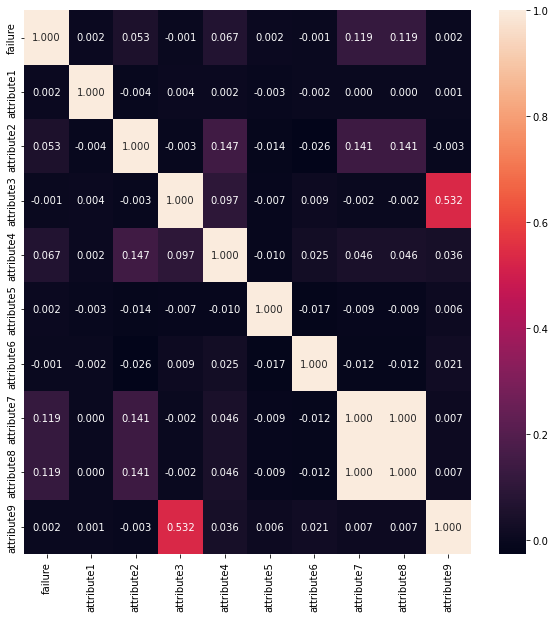

In [6]:
#Observing correlations between attributes
fig = plt.figure(figsize = (10, 10))
sns.heatmap(df.corr(),annot = True, fmt=".3f");

Identifying if there is any immediate correlation between the attributes (without data manipulation), this correlation table shows that there are no strong correlations between any of the attributes with the exception of the correlation score between "attribute3" and "attribute9": 0.532366 and a 1-to-1 correlation between "attribute7" and "attribute8".

In [7]:
#Checking for null values
df.isnull().sum()

date          0
device        0
failure       0
attribute1    0
attribute2    0
attribute3    0
attribute4    0
attribute5    0
attribute6    0
attribute7    0
attribute8    0
attribute9    0
dtype: int64

In [8]:
#Checking for duplicated data
df.duplicated().sum()

0

### Data Exploration

As the codes above showed no data were duplicated, I moved on to reviewing the data by seeing how many duplicated values existed for each feature which I believe will help in understanding which features had sparse patterns.

In [9]:
#Checking the number of duplicates for each feature
col = ['device', 'attribute1', 'attribute2', 
       'attribute3', 'attribute4', 'attribute5', 
       'attribute6', 'attribute7', 'attribute8', 
       'attribute9']

#Empty list to collect number of duplicates
dup = []

#For loop to collect number of duplicates for each feature
for c in col:
    dup.append(df[c].duplicated().sum())

#Create table to contain results
dup_df = pd.DataFrame(columns = ['feature', 'no. duplicated'])
dup_df['feature'] = col
dup_df['no. duplicated'] = dup

dup_df

,feature,no. duplicated
0,device,123326
1,attribute1,616
2,attribute2,123936
3,attribute3,124447
4,attribute4,124379
5,attribute5,124434
6,attribute6,79656
7,attribute7,124466
8,attribute8,124466
9,attribute9,124429


The table above aligns with what we saw when we initially reveiwed the dataset's head and tail functions where attributes that were not attribute1 and attribute 6 demonstrated a sparse pattern (mostly repeats of 0s) based on the high number of duplicated values. I also noticed that the device serial numbers had a high number of duplicates, which makes sense as each truck can undergo services multiple times.

In [10]:
#Checking how many times a device was recorded (in use)
df['device'].value_counts()

S1F0FGBQ    304
W1F0SJJ2    304
Z1F0GE1M    304
Z1F0KJDS    304
Z1F0KKN4    304
           ... 
Z1F0LT6P      5
Z1F0LT6Z      5
W1F1CJKT      5
S1F04KSC      4
W1F0WJFT      3
Name: device, Length: 1168, dtype: int64

Through checking the number of times that a serial number is recorded, it is apparent that some devices were serviced significantly more than others. This could be due to some devices traveling longer distances than others or are older vehicles that lead to higher amount of maintenance. Anyways, I went ahead and selected the first serial number, W1F0JXDL, with the highest number of counts from the result above to further investigate. 

In [11]:
#Selecting data for a random device with the highest amount of records
df[df['device'] == 'W1F0JXDL']

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
589,2015-01-01,W1F0JXDL,0,233729960,16,0,0,7,198059,0,0,0
1752,2015-01-02,W1F0JXDL,0,8791896,16,0,0,7,199406,0,0,0
2915,2015-01-03,W1F0JXDL,0,28936872,16,0,0,7,200788,0,0,0
4078,2015-01-04,W1F0JXDL,0,51665248,16,0,0,7,202121,0,0,0
5239,2015-01-05,W1F0JXDL,0,73345160,16,0,0,7,203440,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
124357,2015-10-27,W1F0JXDL,0,87243936,160,0,0,10,353176,0,0,0
124388,2015-10-29,W1F0JXDL,0,78750848,160,0,0,10,354132,0,0,0
124419,2015-10-30,W1F0JXDL,0,15667280,160,0,0,10,354944,0,0,0
124450,2015-10-31,W1F0JXDL,0,33975240,160,0,0,10,354969,0,0,0


In [12]:
#Checking the unique values in each feature for the serial number W1F0JXDL
def unique_val(data, colnames, serial):
    for i in colnames:
        print(df[df['device'] == serial][i].unique())

In [13]:
#Checking the unique values for attributes 1-9 for the following serial number
unique_val(df, df.columns[3:], 'W1F0JXDL')

[233729960   8791896  28936872  51665248  73345160  96666296 123758576
 145695832 170127112 187582016 209002648 229193832  13425072  32504400
  52402336  72737072 142722416 166545640 168798392 186715184 199029312
 227991704 187255376 186052016 166364816 164034288 181021128 204805416
 132961792 194837304 228778976  39305216 120071408 114916504 141715704
  73905488 153619264 187135952 235010488  61256520 185306104 200031912
    589840 139913192 133505272  98930016 218262512  30925704  55479408
 129860248 242895848 223537392  29355472  44395192 109887616  62142344
  36945456  39257744  35485552 201205208 242188432  26577616  72650808
 137427504 173924672 218755304  56279000  95712864  53275656  30998752
 105475064 112693128 138643648 160577952   7207392  14847456  54585344
  72693056 203761600 210529920 236711088  14314920 223665808 243298816
  11080840  34414704  54435352  74301720  96911712 116307584 134609368
  97198856 115233976 189302464 181981000 242055976  39529200  49162936
  6298

In [14]:
#Converting feature "date" from object to datetime.
df['date'] = pd.to_datetime(df['date'])

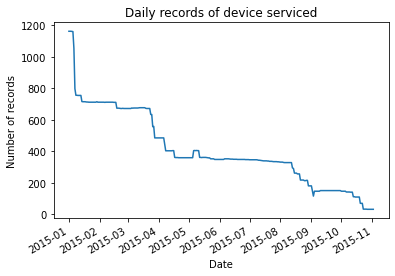

In [15]:
#Counting daily records
df['date'].value_counts().plot()
plt.title('Daily records of device serviced')
plt.xlabel('Date')
plt.ylabel('Number of records')
plt.show();

Based on this chart, we can see a decrease in maintenance records throughout 2015. Some speculations could be that: <br> 1) January has the highest number of maintenance records, which may be due to the severe wear and tear from winter (Nov-Jan)? <br> 2) maybe the company conduct major maintenance earlier in the year so trucks can run smoothly with minimal issues throughout the year?<br> I'm not so sure yet but as ambiguous as the data provided, with no information on location and no descriptive feature names, this is my early speculations.

### Data manipulation/extraction to prepare for visualizations

In [16]:
#Checking number of failures vs non-failures
df['failure'].value_counts()

0    124388
1       106
Name: failure, dtype: int64

Through checking the number of recorded failures vs non-failures recorded in our labeled target: "failure", our data is imbalanced with significantly more records of non-failures vs. failures. 

In this section, we are going to take the latest record of the devices and create a new column that contains the count of how many times the devices had been serviced. Only the more recent record of each device is kept because once a device is serviced, it's past does not really matter. The number of how many times the devices have been serviced can be an indicator of how old and reliable the device is.

In [17]:
#Group by devices with the most recent recording
df2 = df.groupby('device').last().reset_index()
df2.shape

(1168, 12)

In [18]:
#Checking the updated number of failures vs. non-failures
df2['failure'].value_counts()

0    1067
1     101
Name: failure, dtype: int64

In [19]:
df2.head()

,device,date,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,S1F01085,2015-01-06,0,128832128,56,0,52,6,409404,0,0,7
1,S1F013BB,2015-05-11,0,115676688,0,0,0,5,689161,0,0,0
2,S1F0166B,2015-01-06,0,7441792,0,3,0,6,404786,0,0,0
3,S1F01E6Y,2015-02-17,0,147350000,0,0,0,12,259491,0,0,0
4,S1F01JE0,2015-01-06,0,185424928,0,0,0,6,412151,0,0,0


In [20]:
#Creating dataframe with records of number of trips each device has made
trip = pd.DataFrame([df['device'].value_counts()]).T.reset_index()
trip.columns = ['device', 'trip_count']
trip

,device,trip_count
0,S1F0FGBQ,304
1,W1F0SJJ2,304
2,Z1F0GE1M,304
3,Z1F0KJDS,304
4,Z1F0KKN4,304
...,...,...
1163,Z1F0LT6P,5
1164,Z1F0LT6Z,5
1165,W1F1CJKT,5
1166,S1F04KSC,4


In the table presented above, I noticed that the first 3 digits in the device serial numbers are common throughout all serial numbers. Based on my knowledge of manufactured products (from working in medical devices), there are often a part of the serial number that refers to either a specific model or product line so I am going to assume that the first 3 digits of each serial number identify the truck models.

In [21]:
#Extracting the first 3 digits of each device serial number since they are repeated throughout different serial numbers, 
#possibly indicating truck "models"
serial = df2['device'].apply(lambda x: x[:3])
serial_num = pd.DataFrame(serial)
serial_num.columns = ['serial']

In [22]:
#Merge number of trips made per device with dataframe
df3 = df2.merge(trip, on = 'device')

#Merge the first 3 values of serial number with dataframe
df4 = pd.concat([df3,serial_num], axis = 1, sort = False)
df4.head()

,device,date,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,trip_count,serial
0,S1F01085,2015-01-06,0,128832128,56,0,52,6,409404,0,0,7,6,S1F
1,S1F013BB,2015-05-11,0,115676688,0,0,0,5,689161,0,0,0,6,S1F
2,S1F0166B,2015-01-06,0,7441792,0,3,0,6,404786,0,0,0,6,S1F
3,S1F01E6Y,2015-02-17,0,147350000,0,0,0,12,259491,0,0,0,48,S1F
4,S1F01JE0,2015-01-06,0,185424928,0,0,0,6,412151,0,0,0,6,S1F


In [23]:
#Splitting data into month and day in their own columns
df4['Month'] = pd.DatetimeIndex(df4['date']).month
df4['Day'] = pd.DatetimeIndex(df4['date']).day
df4.head()

,device,date,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,trip_count,serial,Month,Day
0,S1F01085,2015-01-06,0,128832128,56,0,52,6,409404,0,0,7,6,S1F,1,6
1,S1F013BB,2015-05-11,0,115676688,0,0,0,5,689161,0,0,0,6,S1F,5,11
2,S1F0166B,2015-01-06,0,7441792,0,3,0,6,404786,0,0,0,6,S1F,1,6
3,S1F01E6Y,2015-02-17,0,147350000,0,0,0,12,259491,0,0,0,48,S1F,2,17
4,S1F01JE0,2015-01-06,0,185424928,0,0,0,6,412151,0,0,0,6,S1F,1,6


### Data Visualization

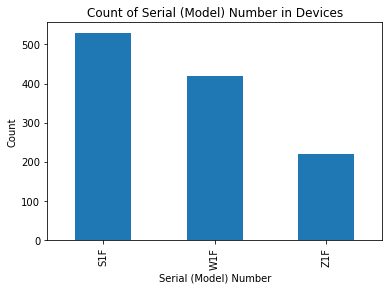

In [24]:
#Determine the number of devices in each group of "model"
df4['serial'].value_counts().plot(kind = 'bar')
plt.title('Count of Serial (Model) Number in Devices')
plt.xlabel('Serial (Model) Number')
plt.ylabel('Count')
plt.show();

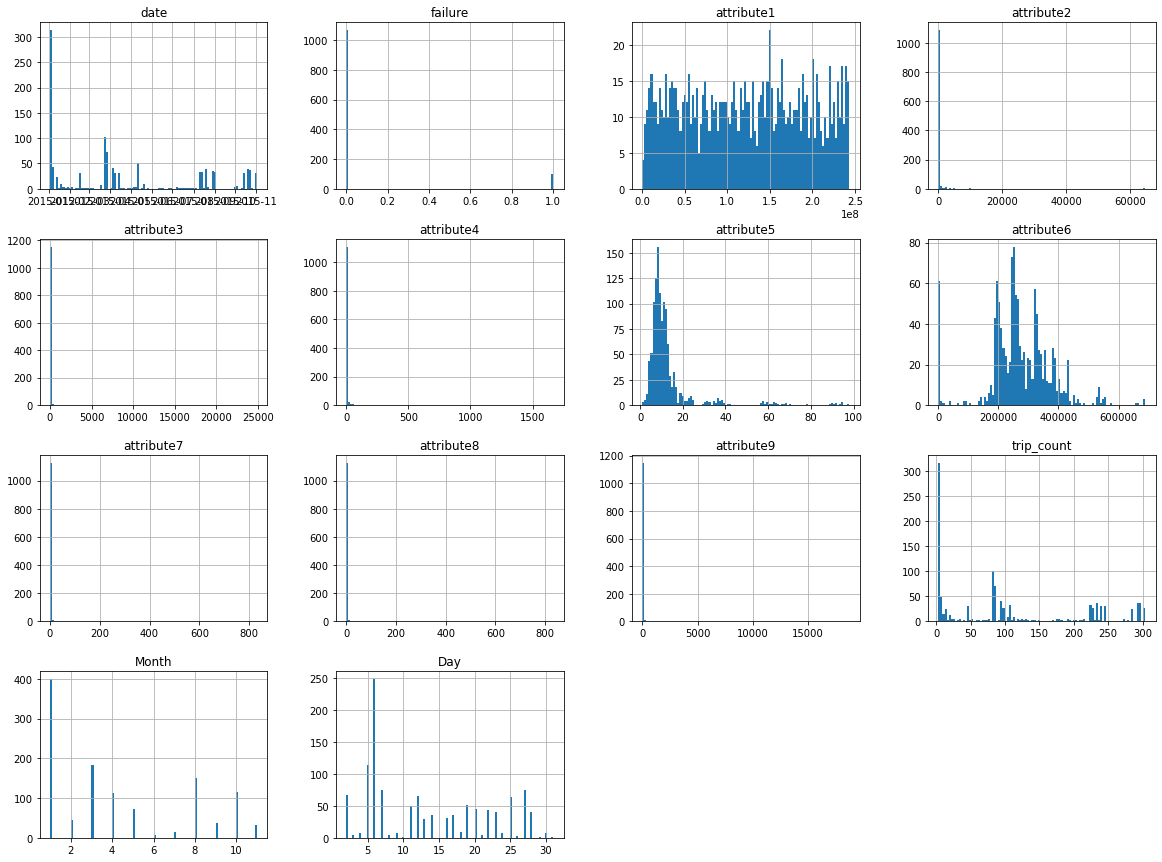

In [25]:
#Viewing distribution of each feature
df4.hist(bins=100, figsize=(20,15))
plt.show()

In [26]:
#Scaling numerical data
scaler = StandardScaler()

scaled = scaler.fit_transform(df4[df4.columns[3:13]])

df4[df4.columns[3:13]] = scaled

## Building the model

In [27]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [28]:
#Setting models to be evaluated
g = GaussianNB()
b = BernoulliNB()
k = KNeighborsClassifier()
log = LogisticRegression()
dtc = DecisionTreeClassifier()
rfc = RandomForestClassifier()
gbc = GradientBoostingClassifier()

algorithms = [g, b, k, log, dtc, rfc, gbc]
names = ['Gaussian', 
         'Bernoulli', 
         'KNearest', 
         'Log', 
         'DecisionTreeClass', 
         'RandomForestClass', 
         'GradientBoostingClassifier']

In [29]:
#Setting up parameters for stratified k-fold for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

#Splitting target data from explanatory data
x, y = df4.drop(['failure', 'device', 'attribute8', 'date'], axis = 1), df4['failure']

#Get dummy variables for categorical attributes
x = pd.get_dummies(x, drop_first = True)

In [30]:
#Function to perform cross-validation
def cross_val_classification():
    accuracy = []
    precision = []
    recall = []
    f1 = []
    auc_roc = []
    
    for i in algorithms:
        accuracy.append(np.mean(cross_val_score(i, x, y, scoring='accuracy', cv=cv, n_jobs=-1)))
        precision.append(np.mean(cross_val_score(i, x, y, scoring='precision', cv=cv, n_jobs=-1)))
        recall.append(np.mean(cross_val_score(i, x, y, scoring='recall', cv=cv, n_jobs=-1)))
        f1.append(np.mean(cross_val_score(i, x, y, scoring='f1', cv=cv, n_jobs=-1)))
        auc_roc.append(np.mean(cross_val_score(i, x, y, scoring='roc_auc', cv=cv, n_jobs=-1)))
                  
    result = pd.DataFrame(columns = ['Accuracy', 
                                     'Precision',
                                     'Recall', 
                                     'F1', 
                                     'AUC-ROC'], index = names)
                  
    result['Accuracy'] = accuracy
    result['Precision'] = precision
    result['Recall'] = recall
    result['F1'] = f1
    result['AUC-ROC'] = auc_roc
        
    return result

In [31]:
#Results from cross-validation
cross_val_classification()

,Accuracy,Precision,Recall,F1,AUC-ROC
Gaussian,0.778431,0.263161,0.349524,0.216867,0.734693
Bernoulli,0.919493,0.577358,0.297143,0.390814,0.824437
KNearest,0.930648,0.864286,0.247619,0.377774,0.824754
Log,0.913510,0.600000,0.079524,0.138705,0.701976
DecisionTreeClass,0.927185,0.618723,0.515238,0.563102,0.748156
RandomForestClass,0.943476,0.795065,0.465238,0.536195,0.960859
GradientBoostingClassifier,0.947757,0.796603,0.514762,0.617601,0.948743


Since the target label is highly imbalanced, Stratified K-fold cross-validation is used to evaluate each classifier's performance. Stratified K-fold cross-validation was chosen because it retains the class distribution in each split of the data. Based on the result table above, we can see that Gradient Boosting Classifier preforms best in this data set. Here, it has the highest F1 score. For a business that requires optimization of device maintenancing, the cost of false positives and negatives are almost equally important. We do not want to spend time and money examining a device that is falsely predicted as positive for needed maintenancing. The costs are in the device downtime for maintenancing and labor. If the device is reported as a false negative for maintenancing, the cost is also high because of device downtime. 